Alunos: Jonas Peixoto e Rafael Maia

Questão 4

Utilize a rede neural perceptron de múltiplas camadas do tipo NARX (rede recorrente) 
para fazer a predição de um passo x^(n+1) da série temporal x(n) = 1 + cos(n + cos(n + cos²(n)), n=0,1,2,3,.... 
Gere inicialmente um conjunto de amostras para o treinamento e um conjunto 
de amostras de teste. Avalie o desempenho mostrando a curva a série temporal, a curva de 
predição e a curva do erro de predição definido como e(n+1)=x(n+1)-x^(n+1).

Sugestão para solução:

Vetor de entrada da rede neural x(n+1)=[x(n), x(n-1), x(n-2), x(n-3)]^t
, corresponde uma rede com 4 dados de entrada. Um neurônio na saída gerando a estimativa x^(n+1). A reposta desejada x(n+1).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
# Definindo a função
def f(x):
  return 1 + np.cos(x + (np.cos(x))**2)

In [ ]:
x = np.linspace(0, 100, 10000)
y = [f(i) for i in x]

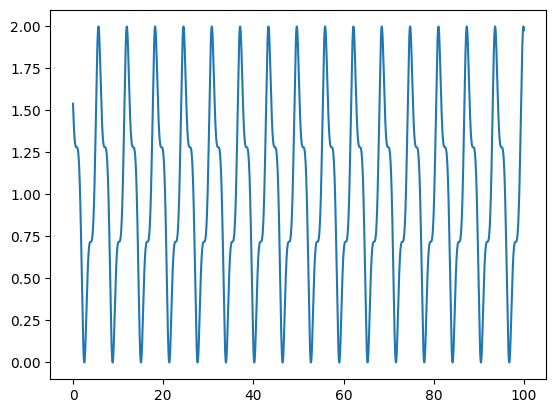

In [ ]:
# plotando os dados
points = 10000
plt.plot(x[:points], y[:points])
plt.show()

In [ ]:
# Dividindo os dados em treinamento e teste
test_size = 2000
x_train = x[:-test_size]
y_train = y[:-test_size]
x_test = x[-test_size:]
y_test = y[-test_size:]

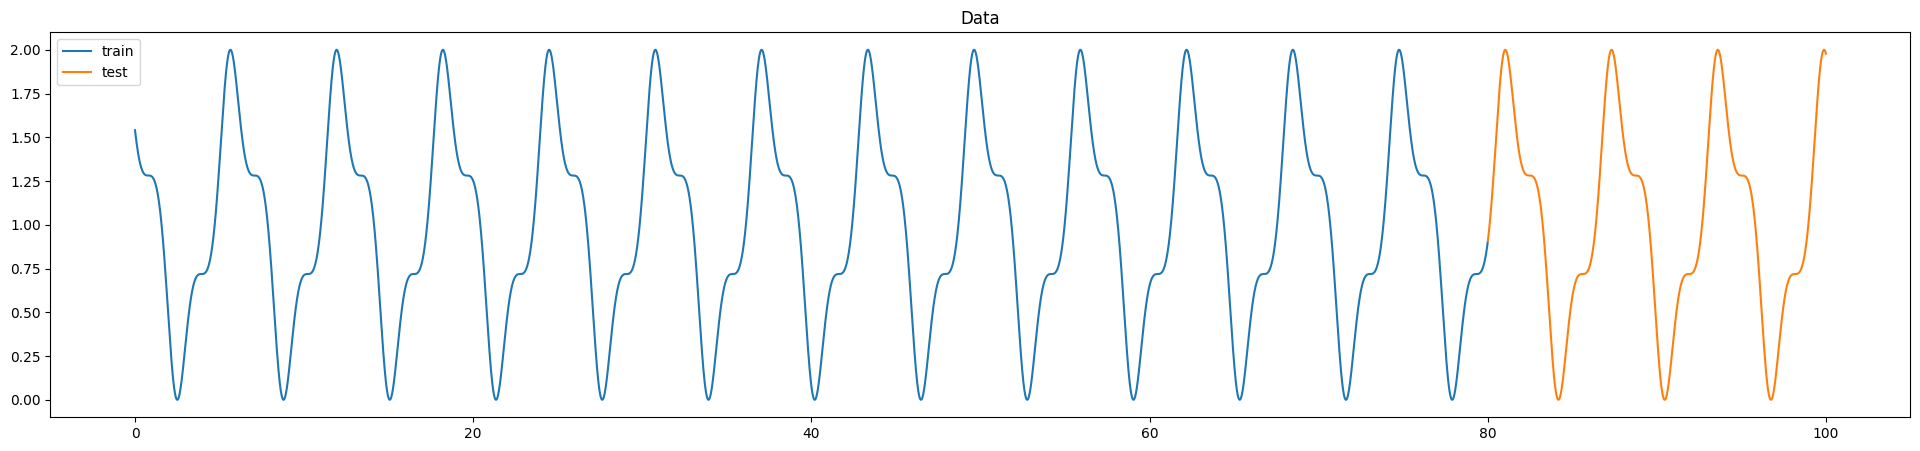

In [ ]:
# plot data
fig, axes = plt.subplots(ncols=1, figsize=(24, 5))
axes.plot(x_train, y_train, label='train')
axes.plot(x_test, y_test, label='test')
axes.set_title('Data')
axes.legend()
plt.show()

In [ ]:
sequence_x = list(TimeseriesGenerator(x_train, x_train, 4, batch_size=1))
sequence_y = list(TimeseriesGenerator(x_train[4:], x_train[4:], 3, batch_size=1))

train_seqs = []
y_train = []
for (x_seq, next_x), (next_seq, _) in zip(sequence_x, sequence_y):
    seq = np.append(x_seq.reshape(4,), next_seq.reshape(3, ))
    
    train_seqs.append(seq)
    y_train.append(next_x)

train_seqs = np.array(train_seqs)
y_train = np.array(y_train)

In [ ]:
sequence_x = list(TimeseriesGenerator(x_test, x_test, 4, batch_size=1))
sequence_y = list(TimeseriesGenerator(x_test[4:], x_test[4:], 3, batch_size=1))

test_seqs = []
y_test = []
for (x_seq, next_x), (next_seq, _) in zip(sequence_x, sequence_y):
    seq = np.append(x_seq.reshape(4,), next_seq.reshape(3, ))
    
    test_seqs.append(seq)
    y_test.append(next_x)

test_seqs = np.array(test_seqs)
y_test = np.array(y_test)

In [ ]:
# construindo o modelo
model = Sequential([
    LSTM(128, input_shape=(7, 1), return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1)
])

model.compile(loss="mean_absolute_error", optimizer="rmsprop")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 7, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 128,417
Trainable params: 128,417
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Treinando o modelo
history = model.fit(
    train_seqs, y_train,
    validation_split=0.1,
    batch_size=8,
    epochs=350,
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
    ]
)

Epoch 1/350
900/900 [==============================] - 19s 9ms/step - loss: 18.8674 - val_loss: 41.5869 - lr: 0.0010
Epoch 2/350
900/900 [==============================] - 7s 7ms/step - loss: 5.8803 - val_loss: 21.8286 - lr: 0.0010
Epoch 3/350
900/900 [==============================] - 6s 7ms/step - loss: 1.8684 - val_loss: 11.9028 - lr: 0.0010
Epoch 4/350
900/900 [==============================] - 7s 8ms/step - loss: 0.9905 - val_loss: 8.1106 - lr: 0.0010
Epoch 5/350
900/900 [==============================] - 6s 7ms/step - loss: 0.8019 - val_loss: 6.1249 - lr: 0.0010
Epoch 6/350
900/900 [==============================] - 7s 8ms/step - loss: 0.7134 - val_loss: 5.6241 - lr: 0.0010
Epoch 7/350
900/900 [==============================] - 6s 7ms/step - loss: 0.6601 - val_loss: 5.2206 - lr: 0.0010
Epoch 8/350
900/900 [==============================] - 7s 8ms/step - loss: 0.6094 - val_loss: 5.2899 - lr: 0.0010
Epoch 9/350
900/900 [==============================] - 6s 7ms/step - loss: 0.5816 -

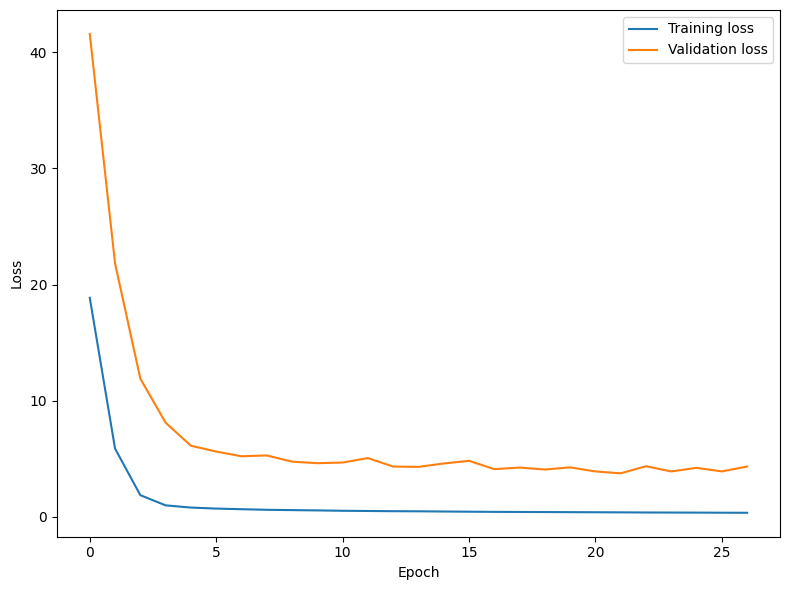

In [ ]:
# plotando a perda (Loss)
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label='Validation loss')

ax.legend()
ax.set(
    ylabel='Loss',
    xlabel='Epoch'
)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# predição
y_pred = model.predict(test_seqs)

63/63 [==============================] - 1s 3ms/step


In [ ]:
erro = y_test - y_pred

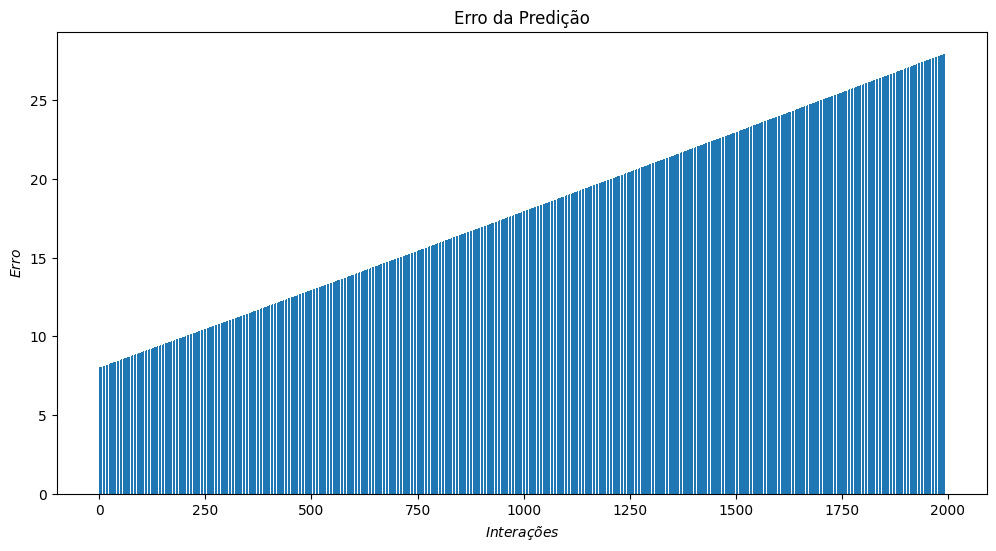

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(
    x=range(len(erro)),
    height=erro.flatten()
)

ax.set(
    title='Erro da Predição',
    ylabel='$Erro$',
    xlabel='$Interações$'
)
plt.show()

# Questão 6

Pesquise sobre redes neurais recorrentes LSTM.
Apresente neste estudo aplicações das 
LSTM deep learning. Seguem abaixo sugestões de aplicações.

i) Processamento de Linguagem Natural

ii) Conversão voz/texto

iii) Tradução de textos

iv) outras aplicações



As redes neurais recorrentes conhecidas como LSTM (Memória de Longo Prazo) têm despertado considerável interesse na comunidade de aprendizado de máquina nos últimos tempos. Em linhas gerais, as redes LSTM se destacam por sua capacidade de retroalimentação, o que lhes permite reter informações tanto de curto quanto de longo prazo. Isso significa que a saída dessas redes é influenciada pelo estado de suas células, o que se revela uma característica crucial quando é necessário que as previsões da rede neural levem em conta o contexto histórico das entradas, não se limitando apenas à última entrada.

Um exemplo prático da utilização de redes neurais LSTM é a predição de séries temporais, que consiste em tentar prever o valor subsequente com base em valores anteriores. Neste caso, foi escolhido um problema específico: prever o que acontecerá com o valor de fechamento de uma ação em n dias (forward_days), tendo como base os m dias anteriores (look_back).

In [ ]:
# LSTM para problema de prever fechamento da ação de uma empresa com regression framing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error







In [ ]:
look_back = 40
forward_days = 10
num_periods = 20

Primeiro, vamos abrir o CSV com o Pandas, colocar as datas como index e manter apenas a coluna que queremos prever, que é o preço de fechamento.

In [ ]:

df = pd.read_csv('/content/amazon.csv')
#set date as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#keep only the 'Close' column
df = df['Close']

df.head()

Date
2010-01-08    133.520004
2010-01-11    130.309998
2010-01-12    127.349998
2010-01-13    129.110001
2010-01-14    127.349998
Name: Close, dtype: float64

In [ ]:
len(df)

2264

Vizualizando os dados

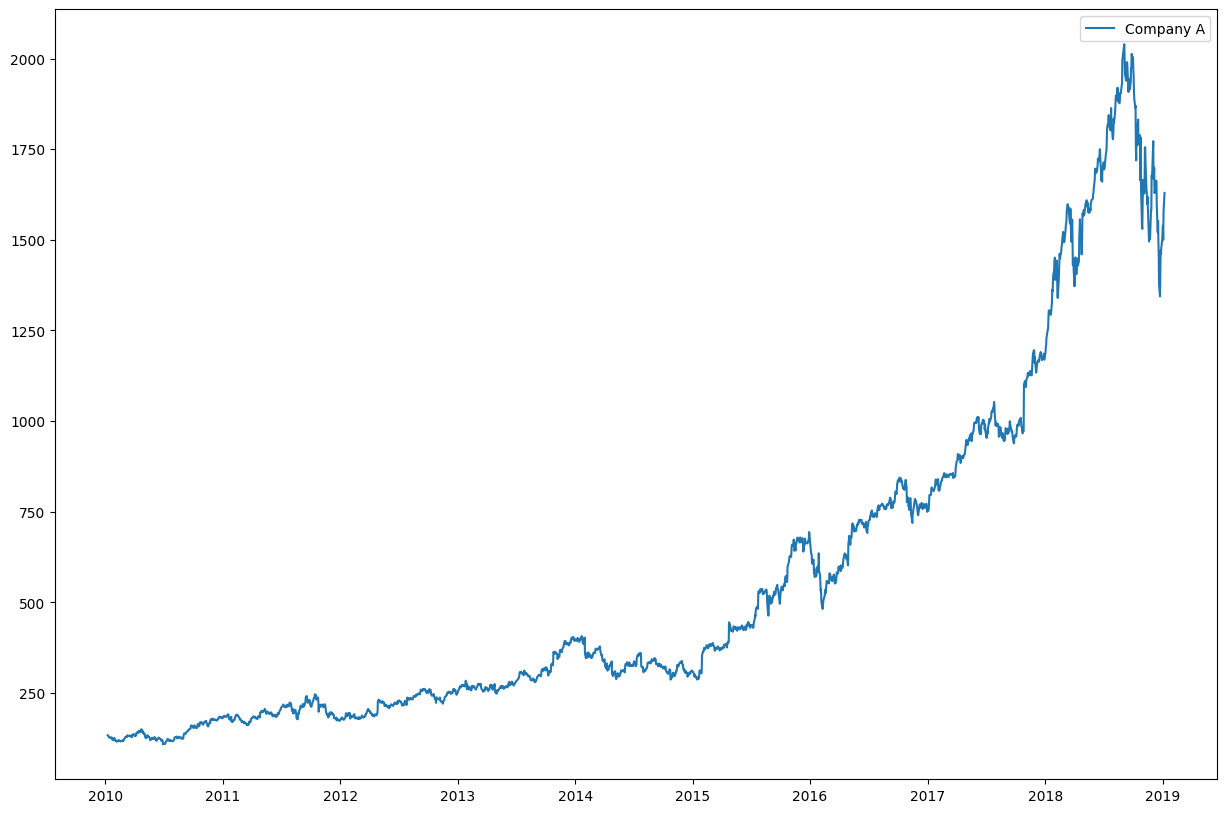

In [ ]:
plt.figure(figsize = (15,10))
plt.plot(df, label='Company A')
plt.legend(loc='best')
plt.show()

Normalizando os dados

In [ ]:
array = df.values.reshape(df.shape[0],1)
array[:5]

array([[133.520004],
       [130.309998],
       [127.349998],
       [129.110001],
       [127.349998]])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
array = scl.fit_transform(array)
array[:5]

array([[0.01290072],
       [0.01123828],
       [0.00970532],
       [0.01061681],
       [0.00970532]])

Dividir os dados em Treino/Validação para o modelo LSTM e os dados de Teste

Vamos separar para os últimos k períodos (num_periods) para testar o modelo. A cada período, o modelo irá prever os próximos n dias. O resto será utilizado para o treinamento (Treino e Validação).

In [ ]:
#split in Train and Test

division = len(array) - num_periods*forward_days

array_test = array[division-look_back:]
array_train = array[:division]

In [ ]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [ ]:
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(1612, 40, 1)
(403, 40, 1)
(20, 40, 1)
(1612, 10)
(403, 10)
(20, 10)


Treinando a LSTM

In [ ]:
#Optionaly, you can load a model
model = load_model('/content/LSTM_compA_LB40_FD10_E50_F50_S30.h5')

In [ ]:
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 50

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)

Epoch 1/50
806/806 - 12s - loss: 0.0015 - val_loss: 2.4777e-04 - 12s/epoch - 14ms/step
Epoch 2/50
806/806 - 6s - loss: 3.7577e-04 - val_loss: 4.3390e-04 - 6s/epoch - 7ms/step
Epoch 3/50
806/806 - 5s - loss: 3.2161e-04 - val_loss: 2.0981e-04 - 5s/epoch - 6ms/step
Epoch 4/50
806/806 - 5s - loss: 2.4984e-04 - val_loss: 3.5245e-04 - 5s/epoch - 6ms/step
Epoch 5/50
806/806 - 5s - loss: 2.6276e-04 - val_loss: 3.0573e-04 - 5s/epoch - 6ms/step
Epoch 6/50
806/806 - 5s - loss: 2.7968e-04 - val_loss: 2.7845e-04 - 5s/epoch - 6ms/step
Epoch 7/50
806/806 - 5s - loss: 2.2765e-04 - val_loss: 2.0215e-04 - 5s/epoch - 7ms/step
Epoch 8/50
806/806 - 5s - loss: 2.6925e-04 - val_loss: 4.2434e-04 - 5s/epoch - 6ms/step
Epoch 9/50
806/806 - 5s - loss: 1.9722e-04 - val_loss: 1.3946e-04 - 5s/epoch - 7ms/step
Epoch 10/50
806/806 - 5s - loss: 2.2263e-04 - val_loss: 1.3680e-04 - 5s/epoch - 6ms/step
Epoch 11/50
806/806 - 5s - loss: 1.7957e-04 - val_loss: 1.4907e-04 - 5s/epoch - 6ms/step
Epoch 12/50
806/806 - 5s - loss

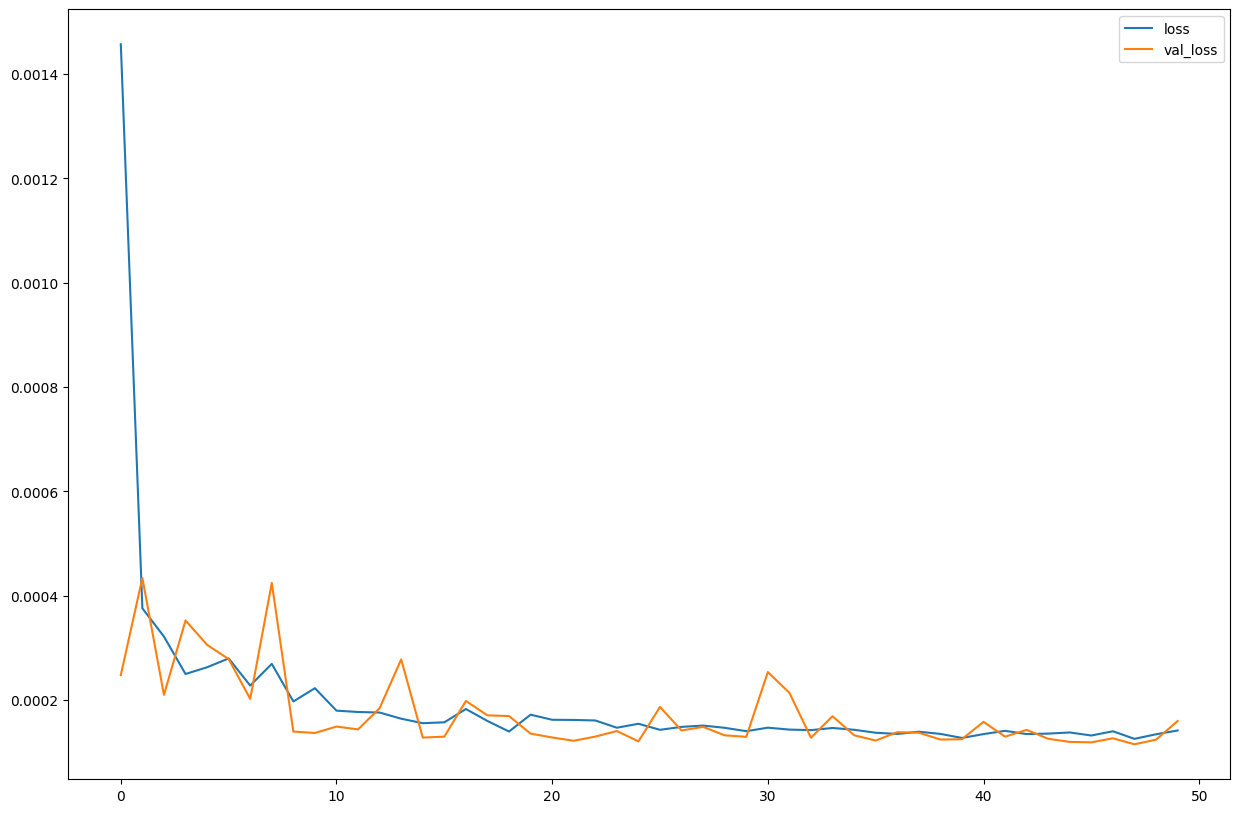

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [ ]:
#Saving the model
file_name = 'Redes/single-company/LSTM_compA_LB{}_FD{}_E{}_F{}_S{}.h5'.format(look_back, forward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer)
model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `Redes/single-company/LSTM_compA_LB40_FD10_E50_F50_S30.h5` to disk


Vamos prever os dados de Teste para o resultado

In [ ]:
Xt = model.predict(X_test)

1/1 [==============================] - 1s 644ms/step


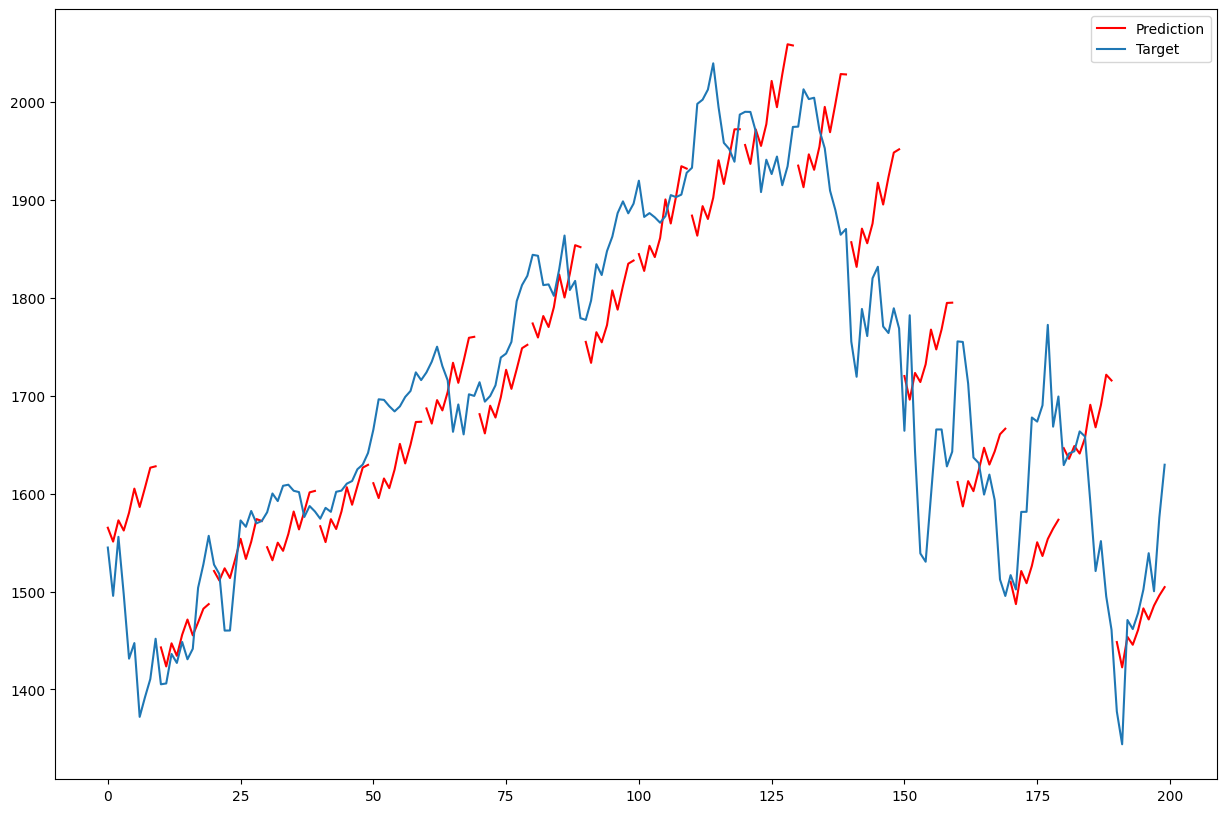

In [ ]:
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') #only to place the label
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

Prever todos os dados para ver como o modelo reage aos dados de Treino e Teste

In [ ]:
division = len(array) - num_periods*forward_days

leftover = division%forward_days+1

array_test = array[division-look_back:]
array_train = array[leftover:division]

In [ ]:
Xtrain,ytrain = processData(array_train,look_back,forward_days,forward_days)
Xtest,ytest = processData(array_test,look_back,forward_days,forward_days)

In [ ]:
Xtrain = model.predict(Xtrain)
Xtrain = Xtrain.ravel()

Xtest = model.predict(Xtest)
Xtest = Xtest.ravel()

1/1 [==============================] - 0s 21ms/step


In [ ]:
y = np.concatenate((ytrain, ytest), axis=0)

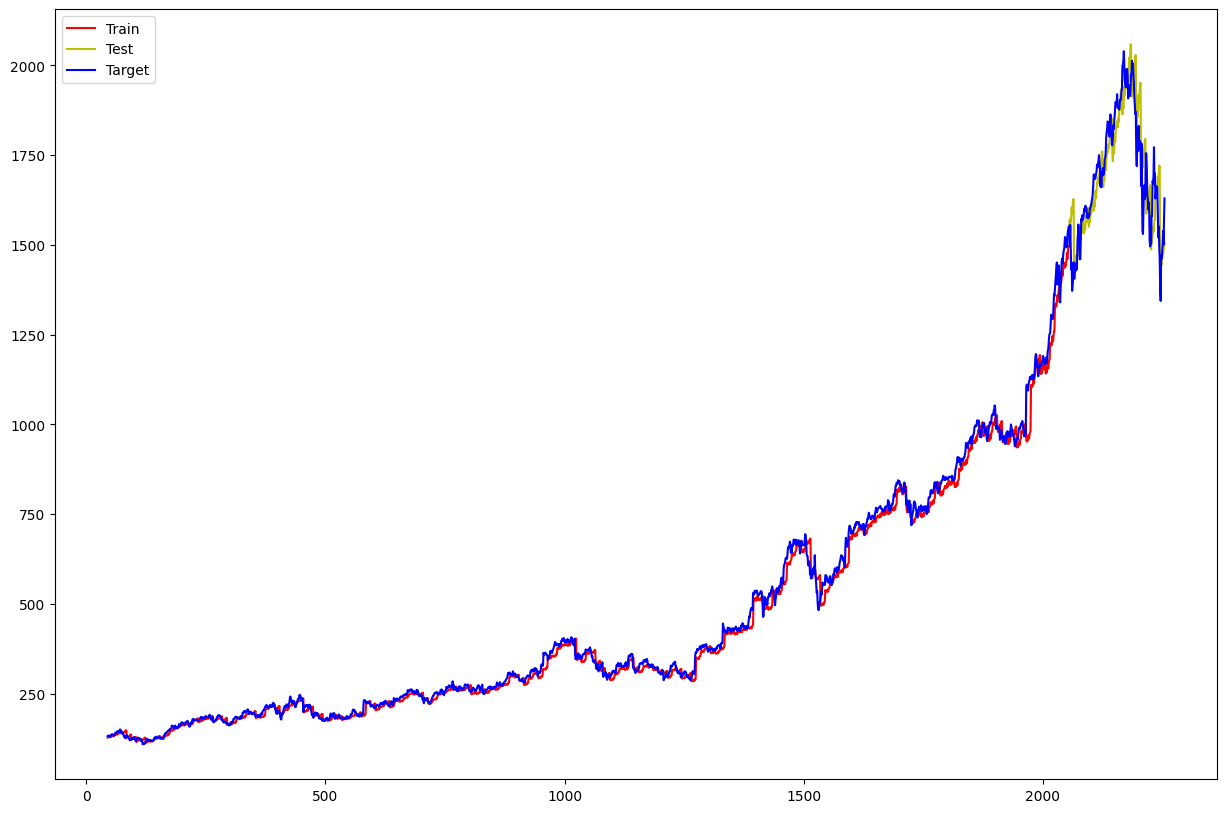

In [ ]:
plt.figure(figsize = (15,10))

# Data in Train/Validation
plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], scl.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train')
# Data in Test
plt.plot([x for x in range(look_back +leftover+ len(Xtrain), len(Xtrain)+len(Xtest)+look_back+leftover)], scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test')

#Data used
plt.plot([x for x in range(look_back+leftover, look_back+leftover+len(Xtrain)+len(Xtest))], scl.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

#Initial data. It should overlap the data used
#plt.plot(scl.inverse_transform(array), color='b', label='Esperado')

plt.legend(loc='best')
plt.show()

Questão 7

Apresente um estudo sobre transferência de conhecimento (transfer learning) no contexto de deep learning

O Transfer Learning (TL) é uma abordagem de Deep Learning que utiliza conhecimento prévio adquirido em uma tarefa para melhorar o desempenho em outra tarefa relacionada. Benefícios do TL incluem a redução da necessidade de dados, melhor generalização e menor tempo de treinamento. O processo do TL envolve selecionar um modelo pré-treinado, remover a camada final, extrair recursos, treinar um novo classificador e, opcionalmente, fazer ajuste fino. O TL é uma técnica valiosa que permite aproveitar o conhecimento prévio para melhorar o desempenho do modelo em novas tarefas.

Um exemplo comum de Transfer Learning no contexto de Deep Learning é o uso de modelos pré-treinados em tarefas de classificação de imagens. Ao invés de treinar uma rede neural do zero com um conjunto de dados limitado, pode-se aproveitar um modelo pré-treinado em um conjunto de dados maior, removendo a camada final e adicionando uma nova camada adaptada à tarefa específica. Isso permite que o modelo pré-treinado transfira seu conhecimento de características visuais gerais para a nova tarefa, acelerando o processo de aprendizado e melhorando o desempenho.

As etapas comuns do Transfer Learning são:

1. Seleção do modelo pré-treinado: Escolha de um modelo pré-treinado adequado treinado em uma tarefa relacionada.

2. Remoção da camada final: Remoção da última camada do modelo pré-treinado para adicionar uma nova camada final.

3. Extração de recursos: Passagem dos dados da nova tarefa pelo modelo pré-treinado para extrair recursos das camadas anteriores.

4. Treinamento do classificador: Adição e treinamento de um novo classificador usando os recursos extraídos.

5. Ajuste fino (fine-tuning): Opcionalmente, ajuste fino do modelo pré-treinado, treinando algumas camadas superiores para se adaptar à nova tarefa.


**Uma Aplicação pratica desse tipo de modelo foi ultilizado na questão 3 onde usamos a rede vgg16 para classificar as imagens do Cifar**